# List all available datasets


In [1]:
from pycaret.datasets import get_data

datasets = get_data("index", verbose=False)
datasets[datasets["Default Task"] == "Regression"]

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
44,automobile,Multivariate,Regression,price,None,202,26,Y
45,bike,Multivariate,Regression,cnt,None,17379,15,N
46,boston,Multivariate,Regression,medv,None,506,14,N
47,concrete,Multivariate,Regression,strength,None,1030,9,N
48,diamond,Multivariate,Regression,Price,None,6000,8,N
49,energy,Multivariate,Regression,Heating Load,Cooling Load,768,10,N
50,forest,Multivariate,Regression,area,None,517,13,N
51,gold,Multivariate,Regression,Gold_T+22,None,2558,121,N
52,house,Multivariate,Regression,SalePrice,None,1461,81,Y
53,insurance,Multivariate,Regression,charges,None,1338,7,N


In [2]:
dataset = "insurance"
target = datasets.set_index("Dataset").loc[dataset]["Target Variable 1"]
train_data = get_data(dataset)
print("Target:", target)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Target: charges


In [3]:
plot_variants = {
    "pipeline": "Schematic drawing of the preprocessing pipeline",
    # "residuals_interactive": "Interactive Residual plots",
    "residuals": "Residuals Plot",
    "error": "Prediction Error Plot",
    # "cooks": "Cooks Distance Plot",
    # "rfe": "Recursive Feat. Selection",
    # "learning": "Learning Curve",
    # "vc": "Validation Curve",
    # "manifold": "Manifold Learning",
    "feature": "Feature Importance",
    # "feature_all": "Feature Importance (All)",
    # "parameter": "Model Hyperparameter",
    # "tree": "Decision Tree",
}
plot_list = list(plot_variants.keys())
plot_list

['pipeline', 'residuals', 'error', 'feature']

# Basic workflow


In [4]:
from pycaret.regression import RegressionExperiment

OPT_CRITERIA = "R2"

exp = RegressionExperiment()

exp.setup(
    data=train_data,
    target=target,
    experiment_name="test-modelling-tools-basic-workflow",
    log_experiment=True,
    log_data=True,
    log_plots=plot_list,
    # log_profile=True,
)

,Description,Value
0,Session id,2078
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Ordinal features,2
8,Numeric features,3
9,Categorical features,3


## Compare Models


In [5]:
best_methods = exp.compare_models(
    exclude=["lightgbm", "dummy", "lar", "omp", "llar"], sort=OPT_CRITERIA, n_select=3
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2508.1818,21080646.9800,4413.5950,0.8449,0.4368,0.2980,0.0370
catboost,CatBoost Regressor,2737.2588,23677582.2045,4727.6598,0.8248,0.4963,0.3461,0.6400
rf,Random Forest Regressor,2686.6253,23628997.0701,4726.8030,0.8246,0.4787,0.3401,0.0810
et,Extra Trees Regressor,2630.6631,26190720.0713,5005.3972,0.8063,0.4904,0.3302,0.0660
ada,AdaBoost Regressor,4199.4295,28588252.4288,5257.5038,0.7931,0.6370,0.7376,0.0220
xgboost,Extreme Gradient Boosting,3176.5448,29983722.1000,5366.5954,0.7722,0.5921,0.4223,0.0370
ridge,Ridge Regression,4197.2167,36388249.5703,5960.9711,0.7290,0.6390,0.4369,0.0190
br,Bayesian Ridge,4192.3166,36388478.8188,5960.9662,0.7289,0.6247,0.4360,0.0190
lr,Linear Regression,4186.8491,36386418.7902,5960.7606,0.7288,0.6259,0.4350,0.3980
lasso,Lasso Regression,4187.0339,36385284.7081,5960.6471,0.7288,0.6294,0.4350,0.0180


## Tune best model (Optimization of Hyperparameters)


In [6]:
tuned = [
    exp.tune_model(method, choose_better=True, n_iter=30, optimize=OPT_CRITERIA)
    for method in best_methods
]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2361.8806,11747467.1685,3427.4578,0.8718,0.3918,0.3519
1,2707.6343,20087684.5947,4481.9287,0.8617,0.4200,0.2850
2,2149.8125,11605263.2756,3406.6499,0.9263,0.4299,0.3415
3,2960.3905,27883259.1576,5280.4601,0.8718,0.4323,0.3378
4,2331.9238,16524700.0070,4065.0584,0.8933,0.4784,0.3461
5,2388.9635,13564762.3329,3683.0371,0.8870,0.4033,0.3110
6,3965.1539,53761458.2859,7332.2206,0.6748,0.6434,0.3088
7,3115.0415,32497892.2167,5700.6923,0.6658,0.4445,0.2718
8,2939.0373,25709716.1051,5070.4749,0.7792,0.4637,0.2623


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2092.7461,10921880.6304,3304.8269,0.8808,0.3819,0.3285
1,2443.3863,18859476.3820,4342.7499,0.8702,0.4049,0.2875
2,2035.0437,10744401.8632,3277.8654,0.9318,0.4306,0.3442
3,2750.0061,26318975.2903,5130.2023,0.8790,0.3904,0.3167
4,2268.7831,14801085.9642,3847.2180,0.9044,0.4717,0.3711
5,2081.3293,11822433.4209,3438.3766,0.9015,0.4160,0.3218
6,3839.0875,52744036.9635,7262.5090,0.6810,0.6386,0.2968
7,2721.6039,29188057.8288,5402.5973,0.6998,0.4284,0.2705
8,2698.9718,24751642.6828,4975.1023,0.7875,0.4681,0.2732


Fitting 10 folds for each of 30 candidates, totalling 300 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1546.8527,9904720.3720,3147.1766,0.8919,0.2836,0.1849
1,1965.8534,18812321.7900,4337.3173,0.8705,0.4079,0.1975
2,1565.0795,9883261.1372,3143.7654,0.9373,0.3433,0.1870
3,2376.6341,25523316.3494,5052.0606,0.8827,0.3511,0.2305
4,1814.8994,14588849.4666,3819.5352,0.9058,0.3686,0.2042
5,1623.8789,11267732.9865,3356.7444,0.9061,0.3639,0.2179
6,3557.5753,51871953.3546,7202.2186,0.6862,0.6750,0.2218
7,2336.6712,28837515.3682,5370.0573,0.7034,0.3791,0.1755
8,2440.6894,25725826.2284,5072.0633,0.7791,0.4377,0.1771


Fitting 10 folds for each of 30 candidates, totalling 300 fits


## Enemble best models


In [7]:
exp.ensemble_model(tuned[0], choose_better=False, method="Bagging")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2163.9245,10496406.6177,3239.8158,0.8855,0.3838,0.3393
1,2646.8001,20139857.3888,4487.7452,0.8614,0.4116,0.2853
2,2016.6296,11089456.9537,3330.0836,0.9296,0.4193,0.3287
3,2677.7275,25339031.9531,5033.7890,0.8835,0.3896,0.3050
4,2316.3162,15162533.9426,3893.9099,0.9021,0.4688,0.3663
5,2195.2808,13005791.7748,3606.3544,0.8916,0.4279,0.3367
6,3869.5474,51725602.4098,7192.0513,0.6871,0.6599,0.2998
7,2710.1442,30425154.9111,5515.9002,0.6871,0.4264,0.2497
8,2795.0239,25864871.4871,5085.7518,0.7779,0.4622,0.2544


BaggingRegressor(estimator=GradientBoostingRegressor(random_state=2078),
                 random_state=2078)

In [8]:
exp.ensemble_model(tuned[0], choose_better=False, method="Boosting")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4199.7488,26579068.2634,5155.4891,0.7100,0.6500,0.8071
1,4160.0485,28067933.6199,5297.9179,0.8068,0.5716,0.6246
2,3765.1953,21429071.0658,4629.1545,0.8640,0.6532,0.7771
3,4139.9950,33046069.9220,5748.5711,0.8481,0.6019,0.6687
4,3671.3484,23290732.4104,4826.0473,0.8496,0.6316,0.6885
5,3891.4853,24881522.0182,4988.1381,0.7927,0.6565,0.7733
6,4805.0558,52806486.0695,7266.8071,0.6806,0.6931,0.5220
7,3944.6383,34924925.4235,5909.7314,0.6408,0.5709,0.5409
8,3787.9228,28498965.7375,5338.4423,0.7553,0.5327,0.4807


AdaBoostRegressor(estimator=GradientBoostingRegressor(random_state=2078),
                  n_estimators=10, random_state=2078)

## Blend Models


In [9]:
exp.blend_models(tuned, choose_better=False, optimize=OPT_CRITERIA)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1820.4374,9823283.2364,3134.2117,0.8928,0.3337,0.2653
1,2214.5876,17973790.4582,4239.5507,0.8763,0.3939,0.2475
2,1831.2801,10343639.8066,3216.1530,0.9344,0.3921,0.2831
3,2538.3468,25226403.7268,5022.5893,0.8841,0.3659,0.2732
4,2084.3519,14289107.4410,3780.0936,0.9077,0.4249,0.3026
5,1917.0210,11411548.3700,3378.0983,0.9049,0.3900,0.2840
6,3737.8088,51741883.3311,7193.1831,0.6870,0.6481,0.2662
7,2537.6830,29289749.4219,5412.0005,0.6988,0.4097,0.2298
8,2611.3789,24815779.5315,4981.5439,0.7869,0.4462,0.2322


VotingRegressor(estimators=[('Gradient Boosting Regressor',
                             GradientBoostingRegressor(random_state=2078)),
                            ('CatBoost Regressor',
                             <catboost.core.CatBoostRegressor object at 0x7ff830860590>),
                            ('Random Forest Regressor',
                             RandomForestRegressor(criterion='absolute_error',
                                                   max_depth=11,
                                                   min_impurity_decrease=0.001,
                                                   min_samples_leaf=3,
                                                   n_estimators=300, n_jobs=-1,
                                                   random_state=2078))],
                n_jobs=-1)

## Stack models


In [10]:
exp.stack_models(estimator_list=tuned, choose_better=False, restack=False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1950.2347,10230585.2135,3198.5286,0.8884,0.3434,0.2869
1,2278.1424,18248278.9272,4271.8004,0.8744,0.4080,0.2650
2,1884.4204,10020365.7787,3165.4961,0.9364,0.3894,0.2913
3,2681.7536,25235473.1351,5023.4921,0.8840,0.3847,0.3090
4,2185.8424,14530655.6490,3811.9097,0.9062,0.4160,0.3131
5,2023.8461,11397221.9545,3375.9772,0.9050,0.3965,0.3005
6,3798.0461,51420041.9244,7170.7769,0.6890,0.6370,0.2815
7,2588.6489,28208225.5723,5311.1416,0.7099,0.3994,0.2399
8,2707.9964,24784227.6807,4978.3760,0.7872,0.4377,0.2438


StackingRegressor(cv=5,
                  estimators=[('Gradient Boosting Regressor',
                               GradientBoostingRegressor(random_state=2078)),
                              ('CatBoost Regressor',
                               <catboost.core.CatBoostRegressor object at 0x7ff830885790>),
                              ('Random Forest Regressor',
                               RandomForestRegressor(criterion='absolute_error',
                                                     max_depth=11,
                                                     min_impurity_decrease=0.001,
                                                     min_samples_leaf=3,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=2078))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1)

In [11]:
exp.stack_models(estimator_list=tuned, choose_better=False, restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1911.2836,10137443.4689,3183.9352,0.8894,0.3350,0.2753
1,2292.1248,17811216.7671,4220.3337,0.8774,0.4097,0.2591
2,1838.0345,10089097.1271,3176.3339,0.9360,0.3686,0.2658
3,2665.9341,25301420.1830,5030.0517,0.8837,0.3795,0.2991
4,2109.4903,14722800.4030,3837.0302,0.9049,0.4273,0.2909
5,2109.8681,12319566.1921,3509.9240,0.8974,0.3931,0.2878
6,3734.7532,50620673.0805,7114.8207,0.6938,0.6251,0.2636
7,2599.1692,28381505.7140,5327.4296,0.7081,0.3906,0.2204
8,2691.6752,24702774.1851,4970.1885,0.7879,0.4396,0.2324


StackingRegressor(cv=5,
                  estimators=[('Gradient Boosting Regressor',
                               GradientBoostingRegressor(random_state=2078)),
                              ('CatBoost Regressor',
                               <catboost.core.CatBoostRegressor object at 0x7ff830509b50>),
                              ('Random Forest Regressor',
                               RandomForestRegressor(criterion='absolute_error',
                                                     max_depth=11,
                                                     min_impurity_decrease=0.001,
                                                     min_samples_leaf=3,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=2078))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
                  passthrough=True)

## Get Best Model (`AutoML`)


In [12]:
best_model = exp.automl(optimize=OPT_CRITERIA)
best_model

StackingRegressor(cv=5,
                  estimators=[('Gradient Boosting Regressor',
                               GradientBoostingRegressor(random_state=2078)),
                              ('CatBoost Regressor',
                               <catboost.core.CatBoostRegressor object at 0x7ff83084a290>),
                              ('Random Forest Regressor',
                               RandomForestRegressor(criterion='absolute_error',
                                                     max_depth=11,
                                                     min_impurity_decrease=0.001,
                                                     min_samples_leaf=3,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=2078))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1)

## Check model types

check what type of models are returned


In [ ]:
check_types = exp.compare_models(include=["knn", "en", "ridge"], n_select=3)

In [ ]:
print(type(check_types))
print(type(check_types[0]))
print(type(check_types[1]))
print(type(check_types[2]))

# Convenience workflow from `fhdw.modelling`

in the follownig you find a setup with the convenience workflow:


In [ ]:
from fhdw.modelling.pycaret import create_regression_model
from pycaret.datasets import get_data

data = get_data("concrete")
exp, best_model = create_regression_model(
    data=data,
    target="strength",
    exclude=["lightgbm", "dummy"],
    save_strategy="local",
    verbose=True,
    prefix="modelling-tools-test-",
    log_experiment=True,
)

# Make Predictions from MLFlow


In [ ]:
import mlflow

mlflow.get_tracking_uri()

In [ ]:
import mlflow

# following run ID must be changed...
logged_model = "runs:/b1c4b8e1b48d434e8aa4e97b5350ae8d/model"

# TODO: looking for a way to use the "best" model
# this would probably be something about models with 'tags' or 'versions'
# --> do some research here


# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
holdout_data = exp.X_test

loaded_model.predict(holdout_data)

In [ ]:
import mlflow

# from experiment 'modelling-tools-test-strength'
# (information extracted from MLFlow UI)
# Experiment ID '904168178551896028'
# Stacking Regressor; Run ID: '5c081b6776d04f7896a63679c60fe9b5'
# Parent Run 'c027affe9cd0482ba35a522115618201'
logged_model = "runs:/5c081b6776d04f7896a63679c60fe9b5/model"


# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
holdout_data = exp.X_test

loaded_model.predict(holdout_data)

# Evaluation: Plot Model

Available plots:

- `pipeline` - Schematic drawing of the preprocessing pipeline
- `residuals_interactive` - Interactive Residual plots
- `residuals` - Residuals Plot
- `error` - Prediction Error Plot
- `cooks` - Cooks Distance Plot
- `rfe` - Recursive Feat. Selection
- `learning` - Learning Curve
- `vc` - Validation Curve
- `manifold` - Manifold Learning
- `feature` - Feature Importance
- `feature_all` - Feature Importance (All)
- `parameter` - Model Hyperparameter
- `tree` - Decision Tree


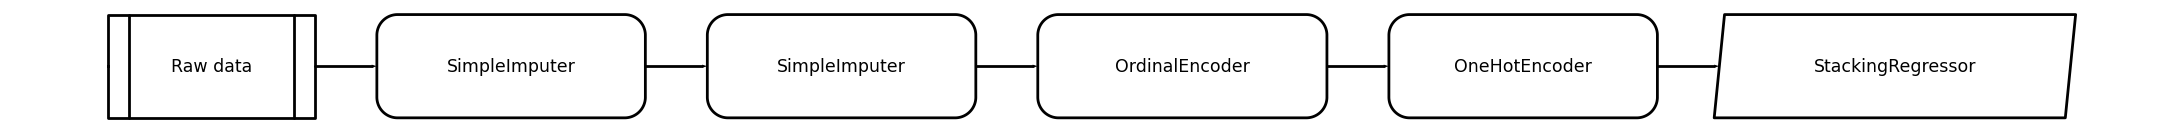

Time: 0:00:00.295930

Generating Plot 'Residuals Plot':



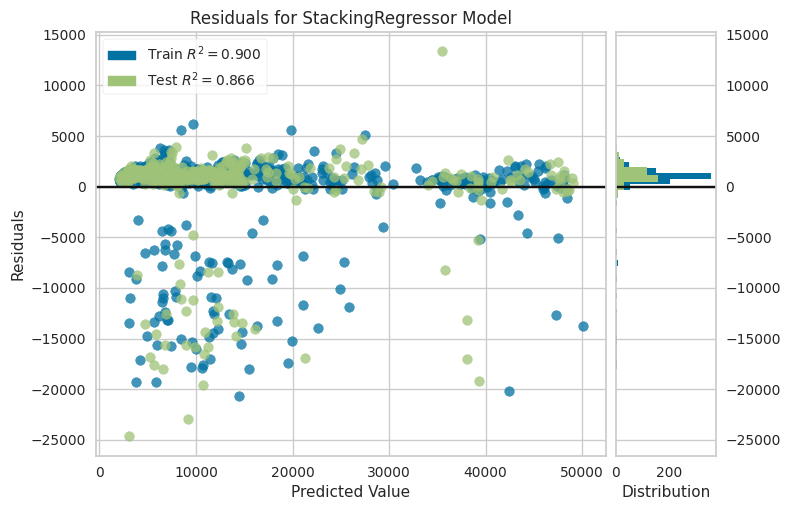

Time: 0:00:00.969775

Generating Plot 'Prediction Error Plot':



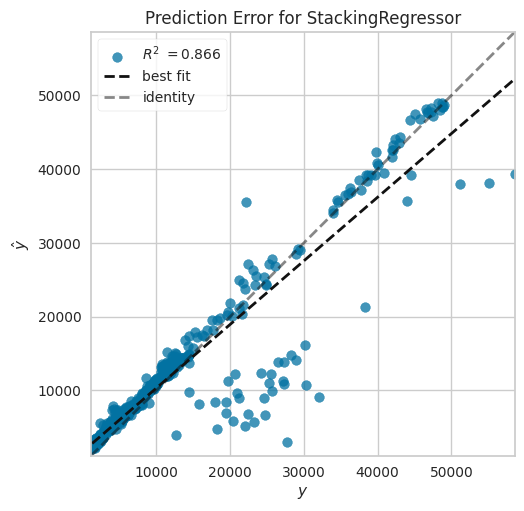

Time: 0:00:00.610274

Generating Plot 'Feature Importance':

plot not supported, Error:
Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.
Time: 0:00:00.008001


In [13]:
from datetime import datetime

for variant, name in plot_variants.items():
    start = datetime.now()
    print(f"\nGenerating Plot '{name}':\n")
    try:
        exp.plot_model(estimator=best_model, plot=variant)
    except TypeError as e:
        print(f"plot not supported, Error:\n{e}")
    print(f"Time: {datetime.now() - start}")

## Plots for specific learning method


In [ ]:
from datetime import datetime

reg = exp.create_model("xgboost")
reg_tuned = exp.tune_model(reg, choose_better=True, n_iter=30)

for variant, name in plot_variants.items():
    start = datetime.now()
    print(f"\nGenerating Plot '{name}':\n")
    try:
        exp.plot_model(estimator=reg_tuned, plot=variant)
    except TypeError as e:
        print(f"plot not supported, Error:\n{e}")
    print(f"Time: {datetime.now() - start}")